In [1]:
from PIL import Image, ImageDraw
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

### Loading Face Image

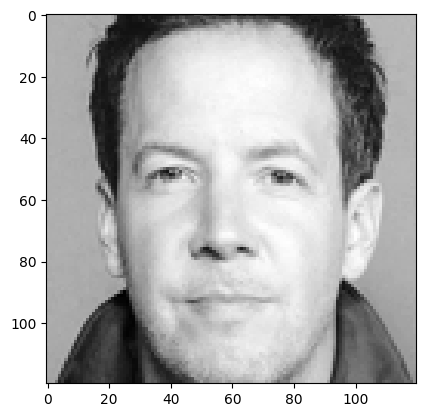

In [2]:
face = np.array(Image.open('imgs/simple_plan_band_small.png'))[70:190, 150:270]

face_grey = Image.fromarray(face).convert('L')

face_grey

plt.imshow(face_grey, cmap='gray');

In [3]:
face_grey_arr = np.array(face_grey)

### Integral Images

Our task is to engineer haar features in order to get feature vector high values when the input image is a image of face. To efficiently compute Harr features, we have to compute integral image first.

In [4]:
@jit(nopython=True)
def integral_image(image: np.ndarray) -> np.ndarray:
    """
    Computes the integral image efficiently
    Returns the integral image of the input image.
    """

    integral_image = np.zeros(image.shape)
    integral_image[0] = np.cumsum(image[0])
    for i in range(1, image.shape[0]):
        integral_image[i][0] = integral_image[i-1][0] + image[i][0]
    for i in range(1, image.shape[0]):
        for j in range(1, image.shape[1]):
            integral_image[i, j] = image[i, j] + integral_image[i-1, j] + integral_image[i, j-1] - integral_image[i-1, j-1]
    return integral_image

In [5]:
integral_image(
    np.array((
        [1, 2, 3],
        [4, 1, 5],
        [2, 1, 3]
    ))
)

array([[ 1.,  3.,  6.],
       [ 5.,  8., 16.],
       [ 7., 11., 22.]])

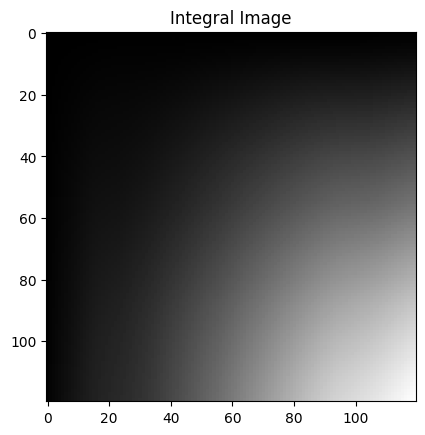

In [6]:
plt.title("Integral Image")
plt.imshow(integral_image(face_grey_arr), cmap= 'gray');

### Haar features

Now we will develop objects to compute haar features for images.

In [7]:
class Haar:

    def __init__(
            self, _positives: list[tuple[int, int, int, int]],
            _negatives: list[tuple[int, int, int, int]],
        ):
        self.whites = []
        self.blacks = []

        for i in range(len(_positives)):
            self.whites.append(
                (_positives[i][0]/120, _positives[i][1]/120,
                 _positives[i][2]/120, _positives[i][3]/120,)
            )

        for i in range(len(_negatives)):
            self.blacks.append(
                (_negatives[i][0]/120, _negatives[i][1]/120,
                 _negatives[i][2]/120, _negatives[i][3]/120,)
            )

    def _get_rect(sefl, rect: tuple[float, float, float, float], pix : int):

        l = []
        for i in rect:
            l.append(int(i * pix))

        return tuple(l)

    def draw_on_img(self, _image: Image.Image) -> Image.Image:
        img = _image.copy()
        imdraw = ImageDraw.Draw(img)

        for xy in self.whites:
            xy = self._get_rect(xy, img.size[0])
            imdraw.rectangle(
                xy, fill= "#ffffff",
                outline= "#000"
            )

        for xy in self.blacks:
            xy = self._get_rect(xy, img.size[0])
            imdraw.rectangle(
                xy, fill= "#000000",
                outline= "#000"
            )

        return img

    def compute(self, integral_image: np.ndarray) -> float:

        s = 0
        for white in self.whites:
            white = self._get_rect(white, integral_image.shape[0])
            if white[0] == 0 and white[1] == 0:
                s += integral_image[white[3]][white[2]]
                continue

            if white[0] == 0:
                s += integral_image[white[3]][white[2]] - integral_image[white[1]][white[2]]
                continue

            if white[1] == 0:
                s += integral_image[white[3]][white[2]] - integral_image[white[3]][white[0]]
                continue

            s += integral_image[white[3]][white[2]] - integral_image[white[3]][white[0]] \
                - integral_image[white[1]][white[2]] + integral_image[white[1]][white[0]]

        s_black = 0
        for black in self.blacks:
            black = self._get_rect(black, integral_image.shape[0])
            if black[0] == 0 and black[1] == 0:
                s_black -= integral_image[black[3]][black[2]]
                continue

            if white[0] == 0:
                s_black -= integral_image[black[3]][black[2]] - integral_image[black[1]][black[2]]
                continue

            if white[1] == 0:
                s_black -= integral_image[black[3]][black[2]] - integral_image[black[3]][black[0]]
                continue

            s_black -= integral_image[black[3]][black[2]] - integral_image[black[3]][black[0]] \
                - integral_image[black[1]][black[2]] + integral_image[black[1]][black[0]]
            
        s = s / len(self.whites) + s_black / len(self.blacks)

        return s / integral_image.size

Above can act as a base class! We can use them to create four type of Haar-like features

In [8]:
class EdgeFeature(Haar):

    def __init__(
            self, _rect: tuple[int, int, int, int],
            _horizontal: bool = True, _reverse: bool = False
        ) -> None:

        if _horizontal:
            midx = (_rect[2] - _rect[0])//2 + _rect[0]
            positives = ((_rect[0], _rect[1], midx, _rect[3]), )
            negatives = ((midx, _rect[1], _rect[2], _rect[3]), )
        else:
            midy = (_rect[3] - _rect[1])//2 + _rect[1]
            positives = ((_rect[0], _rect[1], _rect[2], midy), )
            negatives = ((_rect[0], midy, _rect[2], _rect[3]), )

        if _reverse:
            super().__init__(negatives, positives)
        else:
            super().__init__(positives, negatives)

class LineFeature(Haar):

    def __init__(
            self, _rect: tuple[int, int, int, int],
            _horizontal: bool = True, _reverse: bool = False
        ) -> None:

        if _horizontal:
            x_third = (_rect[2] - _rect[0])//3 + _rect[0]
            x_2third = 2*(_rect[2] - _rect[0])//3 + _rect[0]
            positives = (
                (_rect[0], _rect[1], x_third, _rect[3]),
                (x_2third, _rect[1], _rect[2], _rect[3]),
            )
            negatives = ((x_third, _rect[1], x_2third, _rect[3]), )
        else:
            y_third = (_rect[3] - _rect[1])//3 + _rect[1]
            y_2third = 2*(_rect[3] - _rect[1])//3 + _rect[1]
            positives = (
                (_rect[0], _rect[1], _rect[2], y_third),
                (_rect[0], y_2third, _rect[2], _rect[3]),
            )
            negatives = ((_rect[0], y_third, _rect[2], y_2third), )

        if _reverse:
            super().__init__(negatives, positives)
        else:
            super().__init__(positives, negatives)

class RectangleFeature(Haar):

    def __init__(
            self, _rect: tuple[int, int, int, int], _reverse: bool = False
        ) -> None:

        midx = (_rect[2] - _rect[0])//2 + _rect[0]
        midy = (_rect[3] - _rect[1])//2 + _rect[1]
        positives = (
            (_rect[0], _rect[1], midx, midy),
            (midx, midy, _rect[2], _rect[3]),
        )
        negatives = (
            (midx, _rect[1], _rect[2], midy),
            (_rect[0], midy, midx, _rect[3]),
        )

        if _reverse:
            super().__init__(negatives, positives)
        else:
            super().__init__(positives, negatives)

### Choosing Haar features

Now we choose the haar feature that will be best shuited for face detection!

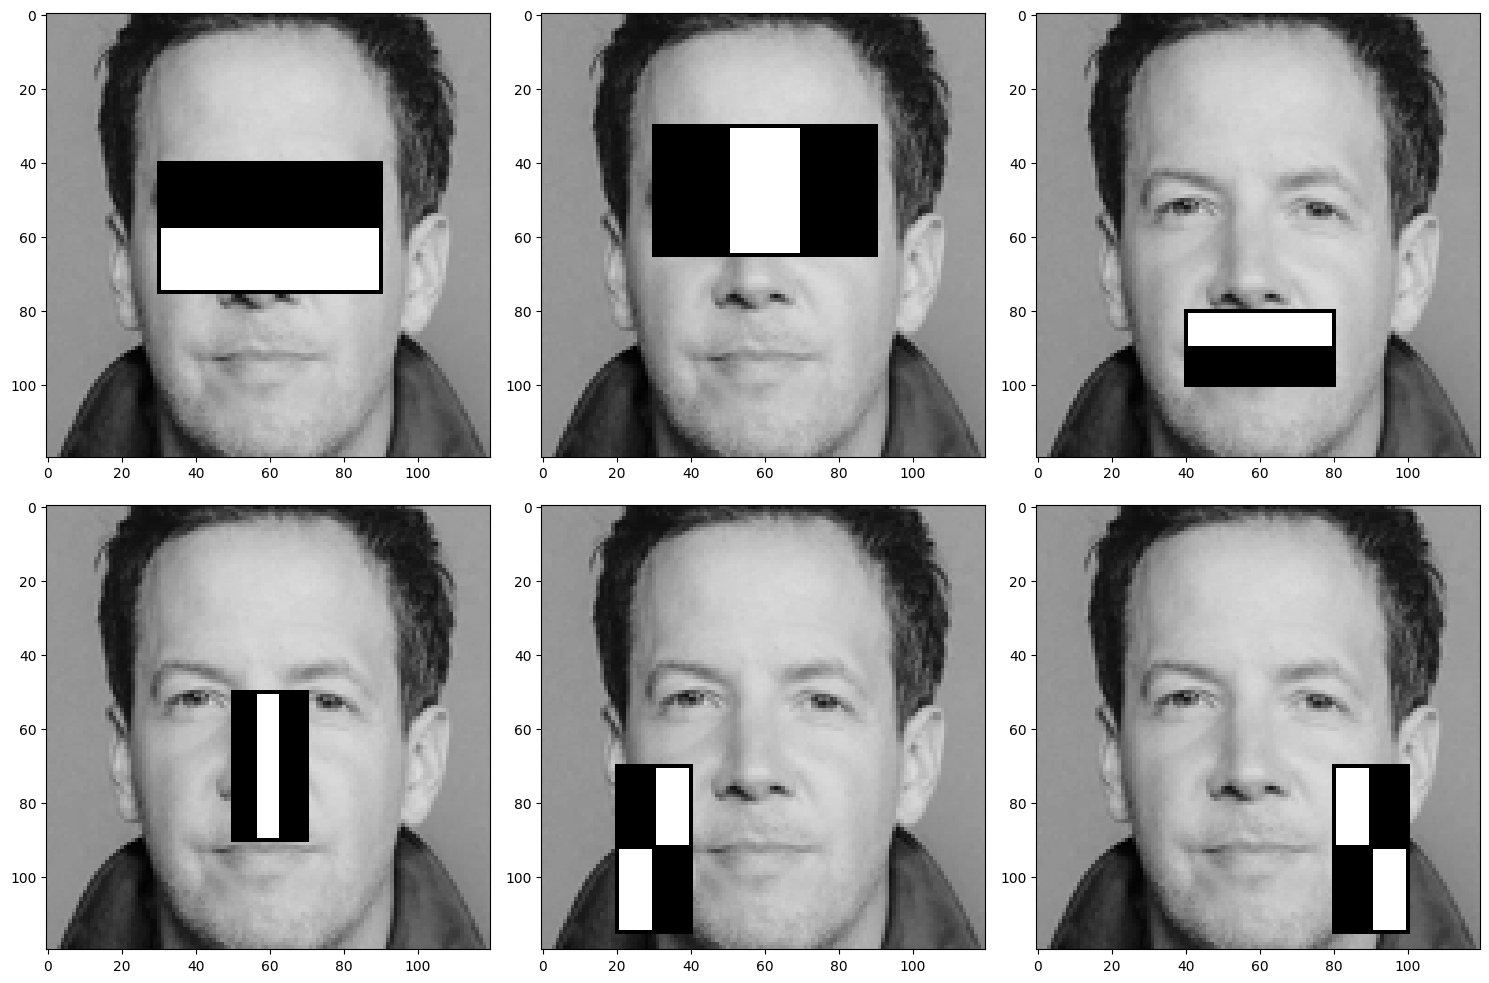

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

filters = []

# Eye and top part of cheeks
filters.append(EdgeFeature((30, 40, 90, 75), False, True))
# Eye and Nostril
filters.append(LineFeature((30, 30, 90, 65), True, True))
# Mouth
filters.append(EdgeFeature((40, 80, 80, 100), False, False))
# Nose
filters.append(LineFeature((50, 50, 70, 90), True, True))
# Left jawline
filters.append(RectangleFeature((20, 70, 40, 115), True))
# Right jawline
filters.append(RectangleFeature((80, 70, 100, 115)))

for i in range(2):
    for j in range(3):
        axs[i, j].imshow(filters[i*3 + j].draw_on_img(face_grey), cmap='gray')

fig.tight_layout()

In [10]:
face_grey_int_img = integral_image(face_grey_arr)

for i, f in enumerate(filters):
    print(f"Filter {i+1}: {f.compute(face_grey_int_img):.3f}")

Filter 1: 2.034
Filter 2: 0.863
Filter 3: 0.495
Filter 4: 0.457
Filter 5: -0.256
Filter 6: -0.367


1st, 2nd, 3rd, 4th features performed well, however, 3rd might fail if the guy had mustach. Thus I will proceed to make a detector using 1st, 2nd and 4th filter.

In [11]:
face_filters = ((filters[0], 1.8), (filters[1], .8), (filters[3], .35))

def check_face(int_img: np.ndarray):

    for f, t in face_filters:
        val = f.compute(int_img)
        if val < t:
            return False

    return True

check_face(face_grey_int_img)

True

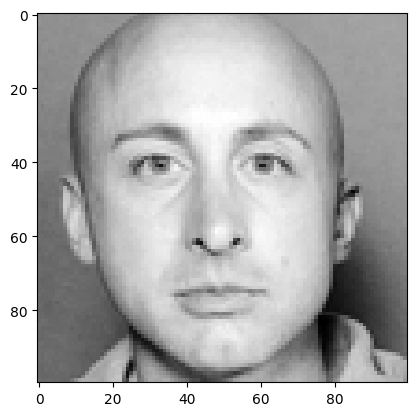

In [12]:
face2 = np.array(Image.open('imgs/simple_plan_band_small.png').convert('L'))[130:230, 0:100]

plt.imshow(face2, cmap='gray');

In [13]:
face2_int_img = integral_image(face2)

check_face(face2_int_img)

True

### Searching Faces about entire image

Let's right the code to automate the searching of the face in image for us.

In [14]:
MIN_SIZE = 60
MAX_SIZE = 300
SCALE_FACTOR = 1.11
STEP_SIZE = .3

def search_faces(image: np.ndarray):

    max_size = min(image.shape[0], image.shape[1], MAX_SIZE)
    
    size = MIN_SIZE

    faces = []

    while size <= max_size:

        for i in range(0, image.shape[0] - size, int(size*STEP_SIZE)):

            for j in range(0, image.shape[1] - size, int(size*STEP_SIZE)):

                int_img = integral_image(image[i:i+size, j:j+size])

                if check_face(int_img):
                    faces.append((j, i, j+size, i+size))

        size = int(size * SCALE_FACTOR)

    return faces

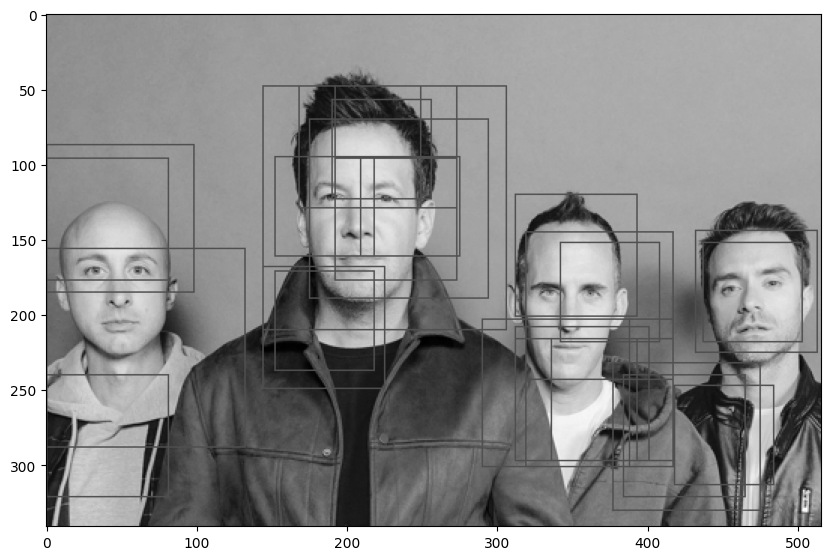

In [15]:
# img = Image.open('imgs/me.jpg').convert('L').resize((1046//3, 1360//3))
img = Image.open('imgs/simple_plan_band_small.png').convert('L')

img_arr = np.array(img)

faces = search_faces(img_arr)

imgd = ImageDraw.Draw(img)

for face in faces:
    imgd.rectangle(face, outline='#FF0000', width=1)

plt.figure(figsize=(10, 10))

plt.imshow(img, cmap='gray');

As you can see, there are lot of false positives. But the model more or less detects the faces very well :)